# Optimisation



In [ ]:
%reset -f

In [ ]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
plt.style.use("default")
np.set_printoptions(linewidth=500,precision=2,suppress=True)

## Fonctions exemples

### Ploter

In [ ]:
def plot_function(ax,fonc):
    x_range=[-2,2]
    y_range=[-2,2]

    x=torch.linspace(x_range[0],x_range[1],100)
    y=torch.linspace(y_range[0],y_range[1],100)

    AA,BB=torch.meshgrid(x,y,indexing="xy")
    CC=fonc(AA,BB)

    #x_range+y_range c'est la concaténation des 2 listes
    ax.imshow(CC,cmap="jet",extent=x_range+y_range,interpolation="bilinear",origin="lower")

### Fonction oscillante

In [ ]:
def oscillating(x0,x1):
    return torch.sin(3*x0)*torch.cos(3*x1)+(x0+x1)/4

fig,ax=plt.subplots()
plot_function(ax,oscillating)

### Des bols bizarres

In [ ]:
def elongated_bowl(x0,x1):
    return 50*x0**2+2*x1**2

In [ ]:
def leaking_bowl(x0,x1):
    return 50*x0**2+2*x1**3

In [ ]:
fig,(ax0,ax1)=plt.subplots(1,2)
plot_function(ax0,elongated_bowl)
plot_function(ax1,leaking_bowl)

## Descente à la vanille

### A la main

In [ ]:
def optimize(fonc,x0,x1,lr,nb):

    xs=[]
    x=torch.tensor([x0,x1],requires_grad=True)

    for i in range(nb):
        y=fonc(x[0],x[1])
        y.backward()

        dy_dx=x.grad
        with torch.no_grad():
            x-=lr*dy_dx
            xs.append(x.detach().clone()) #attention, clone() est nécessaire ici.
            x.grad.zero_()

    return np.stack(xs)

In [ ]:
xs=optimize(oscillating,0.5,0,0.1,10)
xs

In [ ]:
fig,ax=plt.subplots()
plot_function(ax,oscillating)
ax.scatter(xs[:,0],xs[:,1],c="k",marker=".");

### Avec un optimizer

In [ ]:
def apply_optimizer(fonc,x0,x1,lr,Opti,nb=10):

    xs=[]

    x=torch.tensor([x0,x1],requires_grad=True)
    opt=Opti([x],lr=lr)


    for _ in range(nb):
        xs.append(x.detach().clone())


        y=fonc(x[0],x[1])
        y.backward()

        opt.step()
        opt.zero_grad()


    return torch.stack(xs)

Remarque: il serait malin de désactiver les gradients pour l'étape d'optimisation:

    with torch.no_grand():
        opt.step()

Mais torch le fait automatiquement, sauf si on lui dit de ne pas le faire avec l'option

    torch.optim.SGD(differentiable=True)

In [ ]:
Opti=torch.optim.SGD
xs=apply_optimizer(oscillating,0.5,0,0.1,Opti)

In [ ]:
fig,ax=plt.subplots()
plot_function(ax,oscillating)
ax.scatter(xs[:,0],xs[:,1],c="k",marker=".");

### Changer le learning rate

In [ ]:
lr=0.02
Opti=torch.optim.SGD
xs=apply_optimizer(elongated_bowl,1.,1.,lr,Opti)
fig,ax=plt.subplots()
plot_function(ax,elongated_bowl)
ax.plot(xs[:,0],xs[:,1],'w.-');

Cette fonction est difficile à miniser car
*  une des variable la fait varier brusquement
*  une des variable la fait varier lentement

Ce genre de situation arrive fréquemment dans les problèmes d'apprentissage. Pour limiter ce phénomène, il faut "standardisez" les variables descriptives lors du prétraitement des données.

#### → ♡

Reproduisez approximativement ces dessins

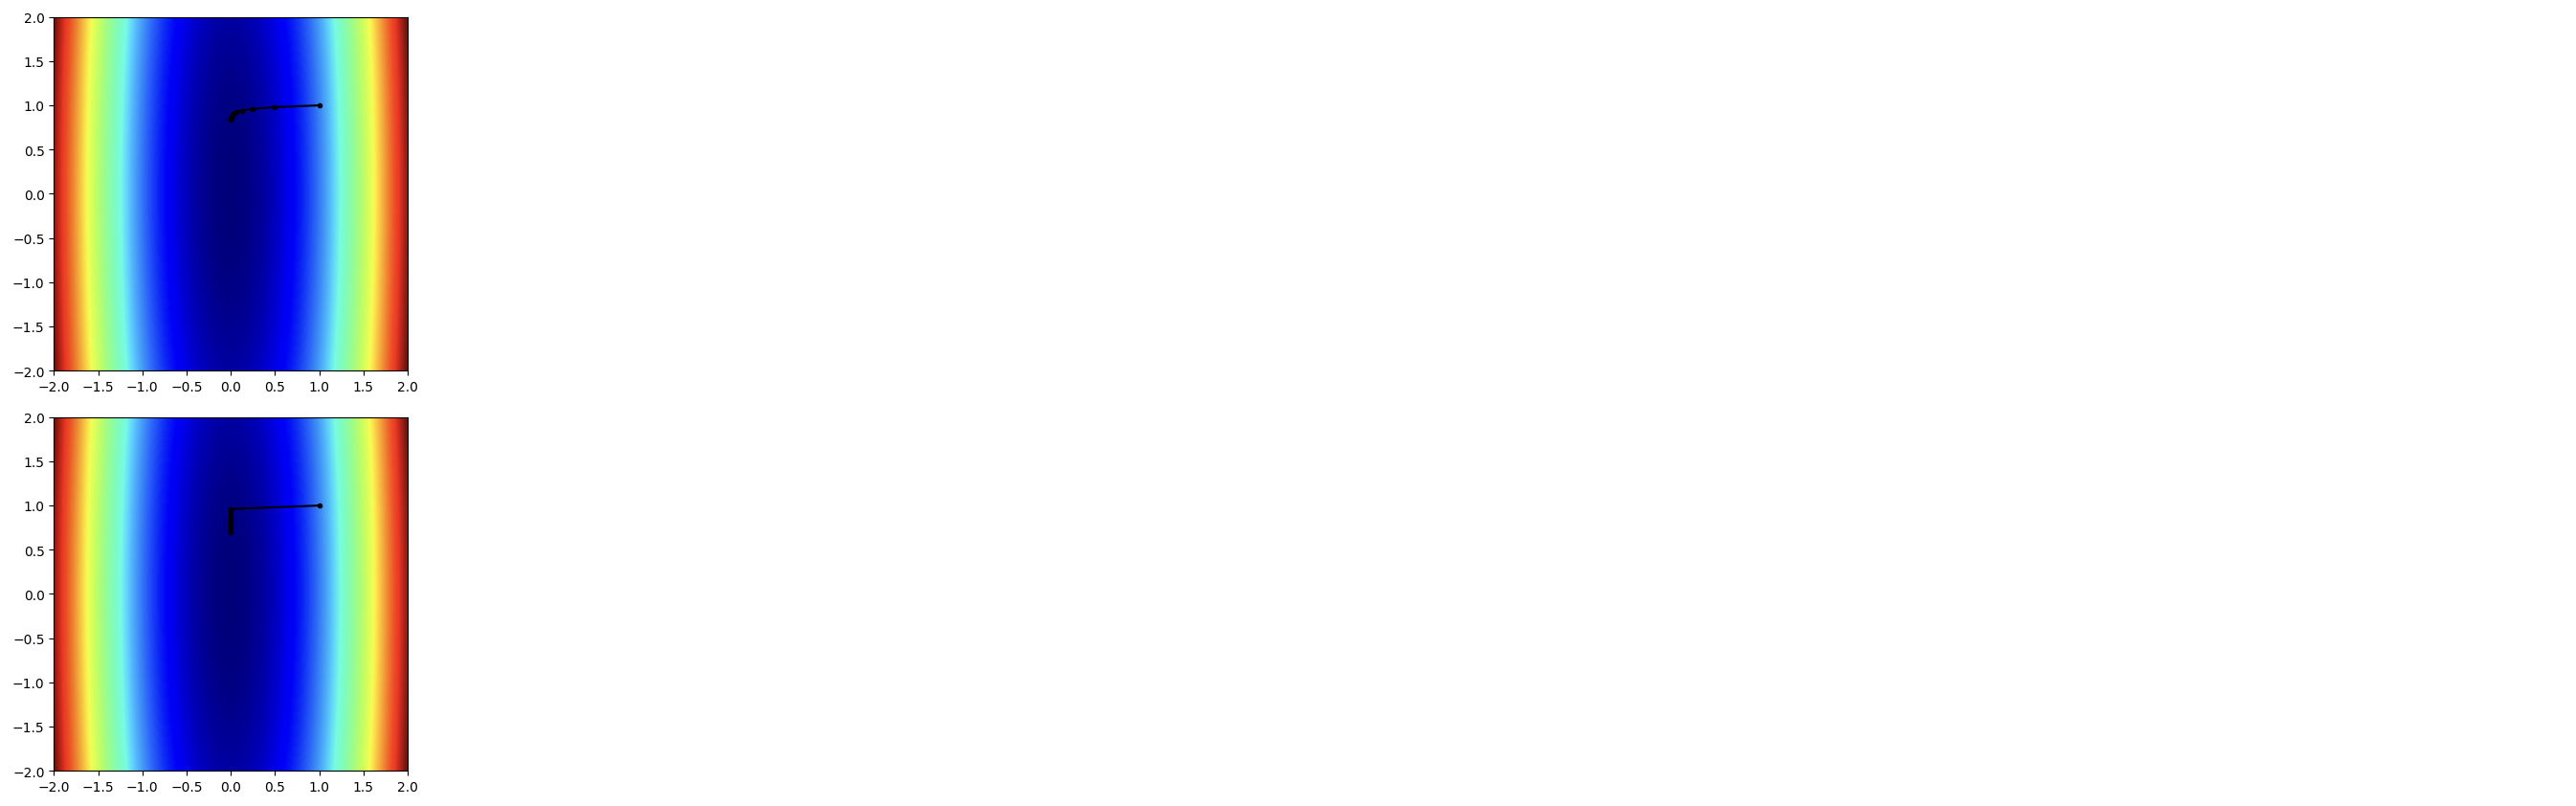

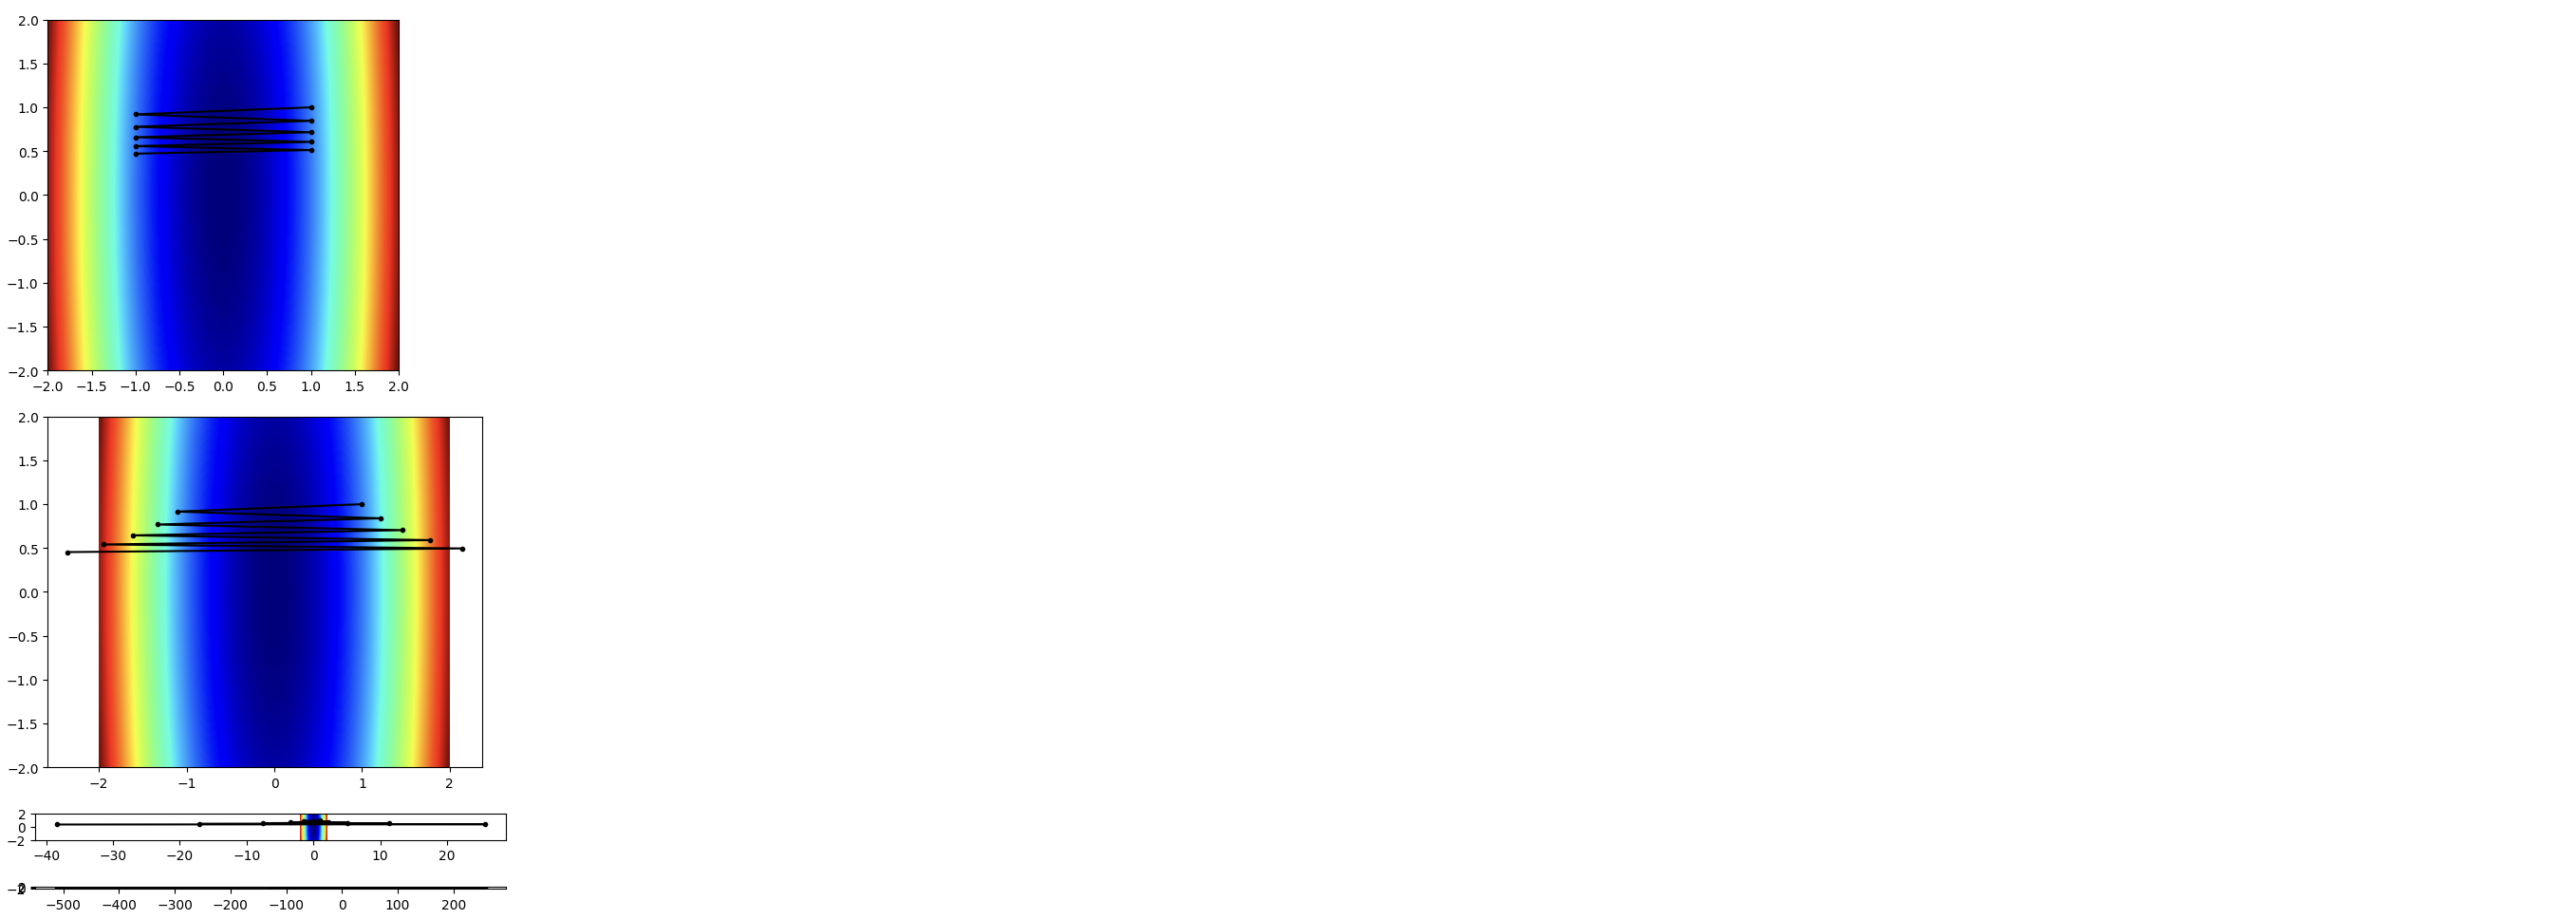

## Méthodes de gradient élaborées



### SG avec Momentum

Le gradient est utilisé comme une accélération, et non comme une vitesse. Pour simuler une sorte de mécanisme de frottement et empêcher que l'élan ne devienne trop important, l'algorithme introduit un nouvel hyperparamètre $\mu$ le "momentum", qui doit être réglé entre 0 (frottement élevée) et 1 (aucune frottement). La valeur typique du momentum est de 0,9.




On veut trouver le minimum de $f(\theta)$. A l'étape $t=0$, on initialise $\theta_0$ aléatoirement et on pose $b_0=0$. Ensuite:
$$
g_t = \nabla_\theta f(\theta_{t-1})
$$

$$
b_t=\mu b_{t-1} + g_t
$$

Enfin, on moditie le paramètre que l'on veut optimiser:
$$
\theta_t = \theta_{t-1} - \gamma b_t
$$

Cela permet à cet optimiser de s'échapper des plateaux beaucoup plus rapidement que la Descente en Gradient.  Elle peut également aider à dépasser les optima locaux.

En raison du momentum, l'optimiseur peut dépasser un peu, puis revenir, dépasser à nouveau, et osciller comme cela plusieurs fois avant de se stabiliser au minimum. C'est l'une des raisons pour lesquelles il est bon d'avoir un peu de friction dans le système : cela élimine ces oscillations et accélère ainsi la convergence.

In [ ]:
Opti=lambda params,lr: torch.optim.SGD(params,lr,momentum=0.9)
xs=apply_optimizer(leaking_bowl,1.,-0.5,1e-3,Opti,nb=30)

fig,ax=plt.subplots()
plot_function(ax,leaking_bowl)
ax.plot(xs[:,0],xs[:,1],'w.-');

### A la main

#### →♡

In [ ]:
def optimize_with_momentum(fonc,x0,x1,lr,momentum,nb):

    xs=[]
    x=torch.tensor([x0,x1],requires_grad=True)
    b=torch.tensor([0,0.])

    for i in range(nb):
        y=fonc(x[0],x[1])
        y.backward()

        dy_dx=x.grad


        with torch.no_grad():
            b=
            x-=lr*b

            xs.append(x.clone().numpy()) #attention, clone() est nécessaire ici.
            x.grad.zero_()

    return np.stack(xs)

In [ ]:
xs=optimize_with_momentum(leaking_bowl,1.,-0.5,1e-3,momentum=0.9,nb=30)

fig,ax=plt.subplots()
plot_function(ax,leaking_bowl)
ax.plot(xs[:,0],xs[:,1],'w.-');

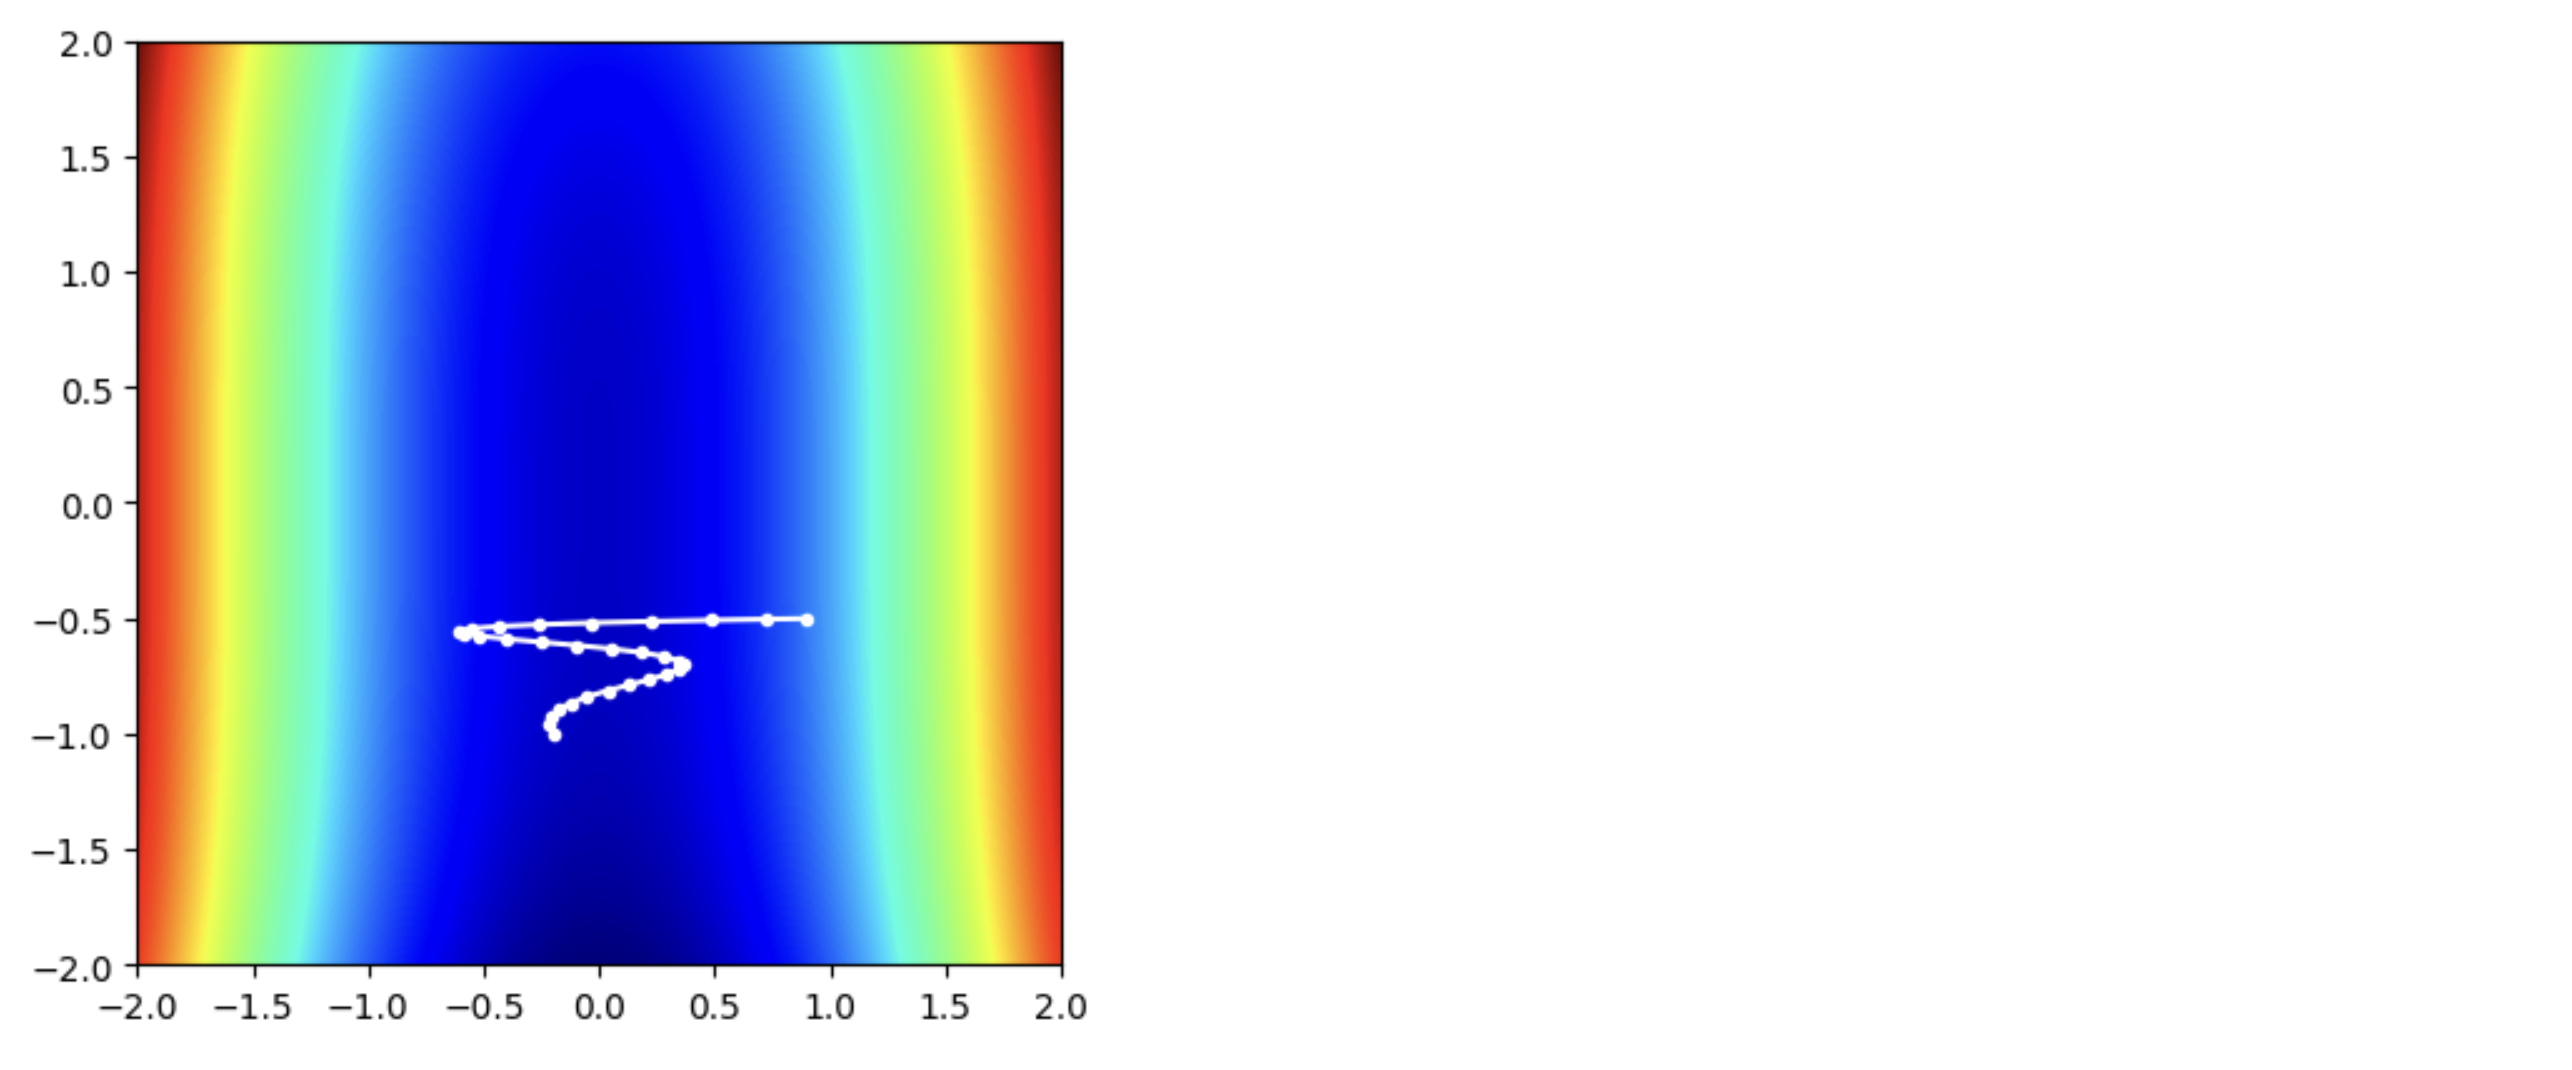

### AdaGrad

Repensons au problème du bol allongé : La descente commence en suivant rapidement la pente la plus raide, puis descend lentement le fond de la vallée. Ce serait bien si l'algorithme pouvait détecter cela très tôt et corriger sa direction pour pointer un peu plus vers l'optimum global.
L'algorithme AdaGrad réalise cela en réduisant le vecteur gradient le long des dimensions les plus raides

On veut trouver le minimum de $f(\theta)$. A l'étape $t=0$, on initialise $\theta_0$ aléatoirement et on pose $s_0=0$. Ensuite:
$$
g_t = \nabla_\theta f(\theta_{t-1})
$$
$$
s_t=s_{t-1} + g^2_t
$$
Puis finalement:
$$
\theta_t = \theta_{t-1} - \gamma {g_t\over \sqrt{s_t} + \epsilon}
$$

 $\epsilon$ est un terme de lissage, par défaut $\epsilon=10^{-10}$.


On voit sur la formule que, cet algorithme diminue le taux d'apprentissage, mais il le fait plus rapidement pour les dimensions à forte pente que pour les dimensions à faible pente. C'est ce qu'on appelle un taux d'apprentissage adaptatif.

AdaGrad fonctionne souvent bien pour les problèmes quadratiques simples, mais malheureusement il s'arrête souvent trop tôt lors de l'apprentissage des réseaux de neurones. Le taux d'apprentissage est tellement réduit que l'algorithme finit par s'arrêter complètement avant d'atteindre l'optimum global.




In [ ]:
Opti=torch.optim.Adagrad
xs=apply_optimizer(leaking_bowl,1.,-0.5,1e-1,Opti,nb=30)

fig,ax=plt.subplots()
plot_function(ax,leaking_bowl)
ax.plot(xs[:,0],xs[:,1],'w.-');

### Adam

Adam, qui signifie "adaptive moment estimation", il combine les idées précédentes. Il y a 2 hyperparamètres $\beta_1$ et $\beta_2$ à choisir dans $[0,1]$. Auquel s'ajoute $\epsilon$ le paramètre de lissage dont la valeur par défaut est `1e-10`. Le paramètre $\gamma$ est le learning rate.





On veut trouver le minimum de $f(\theta)$. A l'étape $t=0$, on initialise $\theta_0$ aléatoirement et on pose $m_0=0$ et $s_0=0$. Ensuite:
$$
g_t = \nabla_\theta f(\theta_{t-1})
$$
Puis pour $t>0$:
$$
m_t=\beta_1 m_{t-1} + (1-\beta_1)g_t
$$
$$
s_t=\beta_2 s_{t-1} + (1-\beta_2)g^2_t
$$
Puis, on booste un peu les valeurs de $m_t$ et $s_t$ en faisant:
$$
m_t ←  {m_t \over 1-\beta_1^t}
$$
$$
s_t ←  {s_t \over 1-\beta_2^t}
$$
 Mais cela a un effet uniquement pour les $t$ petit (car les $\beta^t$ tendent vite vers 0).


Puis:
$$
\theta_t = \theta_{t-1} - \gamma {m_t \over \sqrt{s_t} + \epsilon}
$$

In [ ]:
Opti=torch.optim.Adam
xs=apply_optimizer(elongated_bowl,1.,1.,1e-1,Opti,nb=30)
fig,ax=plt.subplots()
plot_function(ax,elongated_bowl)
ax.plot(xs[:,0],xs[:,1],'w.-');

In [ ]:
Opti=torch.optim.Adam
xs=apply_optimizer(leaking_bowl,1.,1.,1e-1,Opti,nb=30)
fig,ax=plt.subplots()
plot_function(ax,leaking_bowl)
ax.plot(xs[:,0],xs[:,1],'w.-');

### Régler le learning rate pour Adam

En fait, comme Adam est un algorithme au taux d'apprentissage adaptatif, il nécessite moins de réglage que les méthodes plus simples. Nous pouvons souvent utiliser la valeur par défaut $\ell =$ 1e-3. Mais il est bon de tester aussi 1e-1, 1e-2, 1e-4.

Il est bon aussi de faire descendre le learning rate très lentement au fur et à mesure de l'apprentissage pour descentre plus profondémment dans les puits de la loss.

On peut aussi utiliser la technique du recuit simuler: augmenter violemment le learning rate pour sortir d'un minimum local et aller explorer les allentours.

Bien entendu, on mémorise toujours les records successifs qu'on a attend pour pouvoir revenir à la fin au meilleurs endroit exploré; en apprentissage machine on appelle cela l'early stoping.


### En résumé

* Le momentum permet de sortir de minimums locaux, et aussi de ne pas trop rallentir sur des faux-plats.
* Les algorithmes adaptatifs évitent de se faire "aspirer" par la plus grande pente.
* Adam combine les deux idées précédentes.


Attention au learning_rate. Il n'a pas le même ordre de grandeur d'un optimiseur à l'autre.



## Méthode du second ordre


### Principe de la méthode de Newton

La méthode de Newton classique permet de trouver les zéros d'une fonction vectorielle. En l'appliquant l'appliquant à une fonction du type $x\mapsto \nabla f_x$, elle nous permet de trouver un $x$ tel que $\nabla f_x=0$, donc un extrémum local.


Voici l'itération de la méthode:
$$
x_{t+1} = x_t - G_t \nabla f(x_t)
$$
où $G_t$ est l'inverse de la matrice Hessienne $H$ evaluée en $x_t$:
$$
H[i,j] = {\partial^2 f\over x^ix^j}(x_t)
$$


***A vous:*** Si on remplace $f$ par $-f$ dans la formule ci-dessus, que devient-elle? En déduire que cette méthode peut tout à fait converger vers un maximum autant que vers un minimum.

Cette technique est souvent utilisée quand $f$ est une fonction convexe pour trouver son minimum: Elle est plus rapide que la descente de gradient classique. Quand $f$ est quadratique,  elle converge en 1 étape!



### Méthode de quasi-newton

Quand la variable à optimier $x$ est de grande dimension, la matrice hessienne est beaucoup trop grande.

Les méthodes de quasi-newton se contentent de trouver une matrice $G_t$ vérifiant la condition de séquente, càd:
$$
G_t\cdot (x_t-x_{t-1})=\nabla f(x_t) - \nabla f(x_{t-1})
$$


Notons que lorsque l'on travaille dans le contexte `full_batch` càd qu'il n'y a pas de tirage aléatoire dans la formation des batch,  l'algo est beaucoup plus simple.

Si vous voulez en savoir plus:


https://github.com/hjmshi/PyTorch-LBFGS/blob/master/README.md

### Implémentation

Contrairement aux autres optimiseur, `LBFGS` doit prendre en argument une fonction dite de `closure` qui fait les 3 choses suivantes:
* Met à zéro les gradients de l'optimiseur
* Effectue le passage forward
* Effectue le passage backward
* Renvoie l'objectif

In [ ]:
#fonction à minimiser
f=leaking_bowl

#point de départ
x = torch.ones([2, 1],requires_grad = True)


def closure():
    lbfgs.zero_grad()
    objective = f(x[0,:],x[1,:])
    objective.backward()
    return objective


lbfgs = torch.optim.LBFGS([x],
                    history_size=10,
                    max_iter=4,
                    line_search_fn="strong_wolfe")


xs = []
for i in range(20):
    xs.append(x.detach().clone())
    lbfgs.step(closure)

xs=torch.stack(xs)

fig,ax=plt.subplots()
plot_function(ax,f)
ax.plot(xs[:,0],xs[:,1],"w.-");

Cet algorithme est difficile à mettre au point en mode 'stochastique' (= quand les points sont tirés au hasard). Il en existe plusieurs variante, dans notre code nous avons utilisée la version `strong_wolfe`